# Practical Deep Neural Network Performance Prediction for Hyperparameter Optimization

In [20]:
%matplotlib inline
from concurrent import futures
from functools import reduce, wraps
from IPython.display import display
import json
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
from sklearn.utils import shuffle
import sys
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.WARN)
print(tf.__version__)

1.10.0


## Model

In [2]:
N_hidden = 16
model_dir = 'model'

In [3]:
def model(n_hidden):
    def model_loss(y, t):
        t = tf.reshape(t, [-1])
        mse = tf.reduce_mean(tf.square(y - t))
        return mse

    def training(loss):
        optimizer = tf.train.AdamOptimizer()
        train_step = optimizer.minimize(loss)
        return train_step

    x = tf.placeholder(tf.float32, shape=[None, None, 1])
    t = tf.placeholder(tf.float32, shape=[None, 1])
    n_batch = tf.placeholder(tf.int32, shape=[])
    sequence_length = tf.placeholder(tf.int32, shape=[None])
    output_keep_prob = tf.placeholder_with_default(1.0, shape=())
    cell = tf.contrib.rnn.DropoutWrapper(
        tf.nn.rnn_cell.LSTMCell(n_hidden),
        output_keep_prob=output_keep_prob,
        input_size=x.shape[-1],
        variational_recurrent=True,
        dtype=tf.float32)
    zero_state = cell.zero_state(n_batch, tf.float32)
    c_state = tf.placeholder(tf.float32, shape=[None, n_hidden])
    h_state = tf.placeholder(tf.float32, shape=[None, n_hidden])
    outputs, state = tf.nn.dynamic_rnn(
        cell, x, initial_state=tf.nn.rnn_cell.LSTMStateTuple(c_state, h_state),
        sequence_length=sequence_length, dtype=tf.float32)
    h = tf.transpose(state.h)
    W = tf.Variable(tf.truncated_normal([1, n_hidden], stddev=0.01))
    b = tf.Variable(tf.zeros([1], dtype=tf.float32))
    y = tf.sigmoid(tf.matmul(W, h) + b)
    y = tf.reshape(y, [n_batch])
    loss = model_loss(y, t)
    train_step = training(loss)
    init = tf.global_variables_initializer()
    return x, t, n_batch, sequence_length, output_keep_prob, y, \
           c_state, h_state, zero_state, state, loss, train_step, init

In [4]:
# Create model
(x, t, n_batch, s_len,
 output_keep_prob, y, c_state,
 h_state, zero_state, lstm_state,
 loss, train_step, init) = model(n_hidden=N_hidden)

## Training

In [5]:
dataname = 'mnist'
batch_size = 16
epochs = 1000
output_keep_rate = 0.5
N_runs = 100
N_validation = 50
N_train = N_runs - N_validation
N_ensembles = 8

In [6]:
class EarlyStopping():
    def __init__(self, sess, saver,
                 fname, patience=30, verbose=0):
        self._saver = saver
        self._sess = sess
        self._fname = fname
        self.patience = patience
        self.verbose = verbose

        self._loss = float('inf')
        self._step = 0

    def validate(self, loss):
        if self._loss <= loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss
            self._saver.save(self._sess, self._fname)
        return False

In [7]:
def prepare_data(df):
    inputs = []
    outputs = []
    sequence_lengths = []
    for i in range(1, df.shape[1]):
        inputs.append(df.iloc[:, :i])
        tmp = df.iloc[:, i:i + 1]
        tmp.columns = [0]
        outputs.append(tmp)
        sequence_lengths.extend([i] * df.shape[0])
    inputs = reduce(pd.DataFrame.append, inputs)
    outputs = reduce(pd.DataFrame.append, outputs)
    inputs.fillna(0, inplace=True)
    outputs.fillna(0, inplace=True)
    inputs.reset_index(inplace=True, drop=True)
    outputs.reset_index(inplace=True, drop=True)
    sequence_lengths = np.reshape(sequence_lengths, -1)
    X = np.array(inputs).reshape(len(inputs), -1, 1)
    Y = np.array(outputs).reshape(len(outputs), -1)
    return X, Y, sequence_lengths

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.963475,0.970143,0.972731,0.975119,0.977508,0.980096,0.981588,0.982584,0.982982,0.982982,0.983877,0.983877,0.983877,0.983877,0.983877,0.983877,0.983877,0.983877,0.983877,0.983877
1,0.968451,0.968451,0.972930,0.975020,0.975020,0.977607,0.978105,0.978105,0.978901,0.979896,0.979896,0.979896,0.979896,0.980693,0.980693,0.980792,0.983977,0.983977,0.984674,0.986465
2,0.971935,0.971935,0.976015,0.978802,0.978802,0.980892,0.981887,0.985669,0.985669,0.985868,0.985868,0.985868,0.985868,0.985868,0.985868,0.985868,0.985868,0.985868,0.985868,0.985868
3,0.970442,0.970442,0.975717,0.977807,0.978802,0.980792,0.980792,0.980892,0.980892,0.981887,0.984574,0.984674,0.984674,0.984674,0.984674,0.984674,0.984674,0.984674,0.984674,0.984773
4,0.964570,0.972432,0.975617,0.978105,0.979100,0.981290,0.981290,0.981290,0.982683,0.982783,0.982783,0.982783,0.982783,0.982882,0.982882,0.983181,0.983181,0.983678,0.983678,0.983678


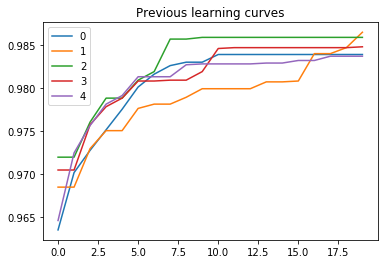

In [35]:
# Train data
df = pd.read_json('%s.json' % (dataname), orient='split')
display(df.head())
df.head().T.plot(title='Previous learning curves')
dlen = df.shape[1]
tmp = df.copy()
for i in range(1, df.shape[1]):
    tmp.iloc[:, i] = (df.iloc[:, i] - df.iloc[:, i - 1]) / (1 - df.iloc[:, i - 1])
    tmp.fillna(0, inplace=True)
df = tmp

In [11]:
# Training
with tf.Session() as sess:
    for e in list(range(N_ensembles)):
        shuffled_idx = np.arange(N_runs)
        np.random.shuffle(shuffled_idx)
        sess.run(init)
        saver = tf.train.Saver()
        early_stopping = EarlyStopping(
                sess, saver, "%s/%s/%d" % (model_dir, dataname, e))
        df_t = df.iloc[shuffled_idx][:N_train]
        tmp = np.array(df_t).reshape(-1)
        X_train, Y_train, SL_train = prepare_data(df_t)
        df_v = df.iloc[shuffled_idx][N_train:]
        X_validation, Y_validation, SL_validation = prepare_data(df_v)
        for epoch in range(epochs):
            X_, Y_, SL_ = shuffle(X_train, Y_train, SL_train)
            N_batches = X_.shape[0] // batch_size
            for i in range(N_batches):
                z = sess.run(zero_state, feed_dict={n_batch: batch_size})
                start = i * batch_size
                end = start + batch_size
                sess.run([train_step, loss], feed_dict={
                    x: X_[start:end],
                    t: Y_[start:end],
                    s_len: SL_[start:end],
                    n_batch: batch_size,
                    output_keep_prob: output_keep_rate,
                    c_state: z[0],
                    h_state: z[1]
                })
            z = sess.run(zero_state, feed_dict={n_batch: len(X_validation)})
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                s_len: SL_validation,
                n_batch: len(X_validation),
                c_state: z[0],
                h_state: z[1]
            })
            print('\rensemble: %s\tepoch: %s\tvalidation loss:%s' % (
                e, epoch, val_loss), end='')
            if early_stopping.validate(val_loss):
                break

ensemble: 7	epoch: 242	validation loss:0.0029982498

## Prediction

In [9]:
dataname = 'mnist'
validation_dataname = 'mnist_test'
ylim = [0.95, 1.0]  # [0, 1]
dlen = 20  # 300
inputlen = 1
plot_ticks = np.array(range(dlen))
N_test_cases = 1  # 20
N_sigma = 2
N_ensembles = 8

In [19]:
models = list(range(N_ensembles))
max_workers = len(models)
saver = tf.train.Saver()
config = tf.ConfigProto(device_count={"GPU": 0})

In [11]:
class Predictor():
    def __init__(self,
                 dataname,
                 validation_dataname,
                 N_sigma,
                 dlen,
                 inputlen,
                 input_df,
                 modelpath):
        self.dataname = dataname
        self.validation_dataname = validation_dataname
        self.N_sigma = N_sigma
        self.dlen = dlen
        self.inputlen = inputlen
        self.input_df = input_df
        self.modelpath = modelpath

    def __call__(self):
        with tf.Session(config=config) as sess:
            sess.run(init)
            saver.restore(sess, self.modelpath)
            sess.graph.finalize()
            predicted = self.input_df.values.tolist()
            z = sess.run(zero_state, feed_dict={n_batch: 1})
            y_, z = sess.run([y, lstm_state], feed_dict={
                x: np.array(predicted).reshape(1, -1, 1),
                n_batch: 1,
                s_len: [len(predicted)],
                c_state: z[0],
                h_state: z[1]
            })
            predicted.append(y_.reshape(-1)[0])
            for _ in range(self.dlen - len(predicted)):
                y_, z = sess.run([y, lstm_state], feed_dict={
                    x: np.array(predicted)[-1:].reshape(1, -1, 1),
                    n_batch: 1,
                    s_len: [1],
                    c_state: z[0],
                    h_state: z[1]
                })
                predicted.append(y_.reshape(-1)[0])
        for i in range(1, len(predicted)):
            predicted[i] = predicted[i - 1] + (1 - predicted[i - 1]) * predicted[i]
        predicted = np.array(predicted)
        return predicted

In [12]:
class MultiPredictor():
    def __init__(self,
                 dataname,
                 validation_dataname,
                 N_sigma,
                 dlen,
                 inputlen,
                 N_ensembles,
                 max_workers):
        self.dataname = dataname
        self.validation_dataname = validation_dataname
        self.N_sigma = N_sigma
        self.dlen = dlen
        self.inputlen = inputlen
        self.N_ensembles = N_ensembles
        self.max_workers = max_workers
        self.models = ['%s/%s/%d' % (model_dir, self.dataname, e) for e in models]
        self.executor = futures.ProcessPoolExecutor(max_workers=self.max_workers)

    def predict(self, input_df):
        predictions = []
        fs = [self.executor.submit(
            Predictor(self.dataname,
                      self.validation_dataname,
                      self.N_sigma,
                      self.dlen,
                      self.inputlen,
                      input_df,
                      m)) for m in self.models]
        for future in futures.as_completed(fs):
            predictions.append(future.result())
        predictions = pd.DataFrame(predictions).iloc[:, input_df.shape[0]:]
        return predictions

    def __del__(self):
        self.executor.shutdown()

In [36]:
def plot(mean, original):
    plt.figure()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.xticks(plot_ticks, plot_ticks + 1)
    plt.ylim(ylim)
    ax = plt.gca()
    plt.plot(mean, color='red', label='Prediction')
    original.T.plot(ax=ax, linestyle='dashed', color='gray', label='Ground truth')
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

test case: 0
number of inputs: 1
predictive mean: 0.9828084261242099
predictive std: 0.0007846972472526188
ground truth: 0.986564


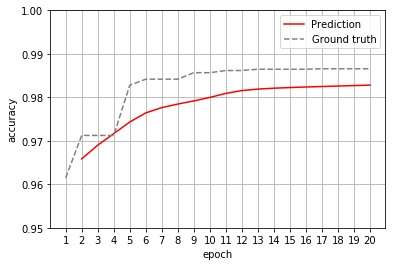

test case: 0
number of inputs: 2
predictive mean: 0.9845828571729797
predictive std: 0.0005189400841878884
ground truth: 0.986564


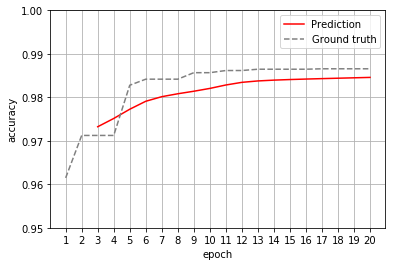

test case: 0
number of inputs: 3
predictive mean: 0.9838942958645751
predictive std: 0.0004802426372715161
ground truth: 0.986564


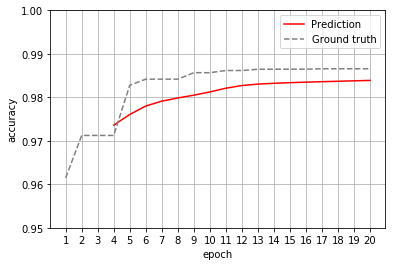

test case: 0
number of inputs: 4
predictive mean: 0.9832994417619269
predictive std: 0.0005039129118147263
ground truth: 0.986564


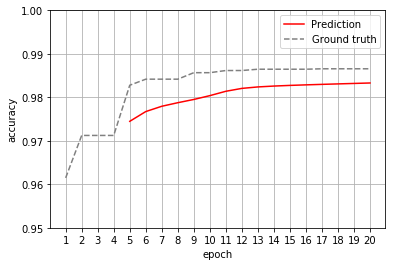

test case: 0
number of inputs: 5
predictive mean: 0.9862716747832435
predictive std: 0.0010705891687547956
ground truth: 0.986564


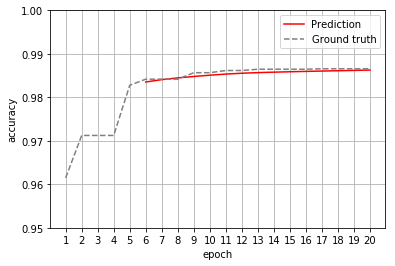

test case: 0
number of inputs: 6
predictive mean: 0.9866320667622309
predictive std: 0.0010411638343490463
ground truth: 0.986564


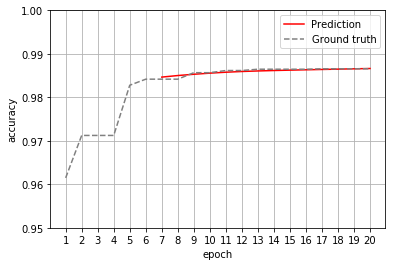

test case: 0
number of inputs: 7
predictive mean: 0.9863178105595968
predictive std: 0.0009177139146090559
ground truth: 0.986564


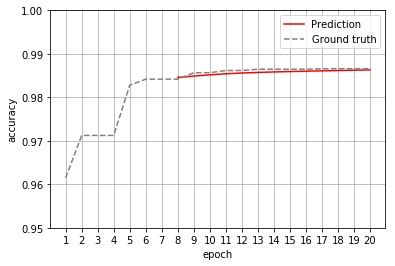

test case: 0
number of inputs: 8
predictive mean: 0.9860348232150422
predictive std: 0.0007843878014747506
ground truth: 0.986564


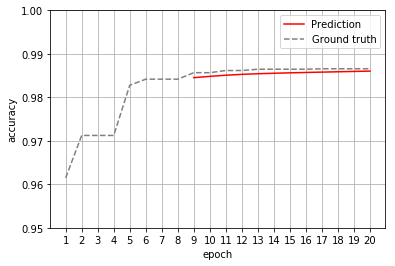

test case: 0
number of inputs: 9
predictive mean: 0.9869562162422549
predictive std: 0.0006433944708444138
ground truth: 0.986564


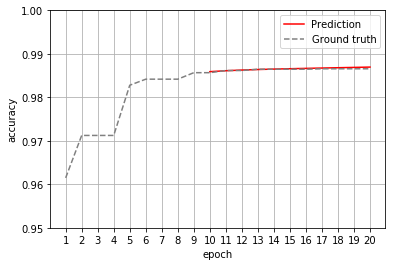

test case: 0
number of inputs: 10
predictive mean: 0.9867520915091901
predictive std: 0.0005704487950481779
ground truth: 0.986564


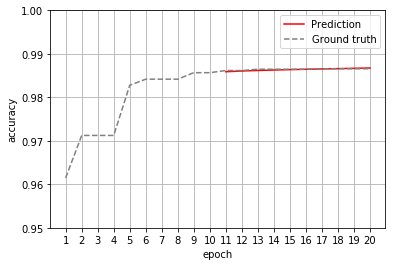

test case: 0
number of inputs: 11
predictive mean: 0.9870073881027711
predictive std: 0.0004910045015181523
ground truth: 0.986564


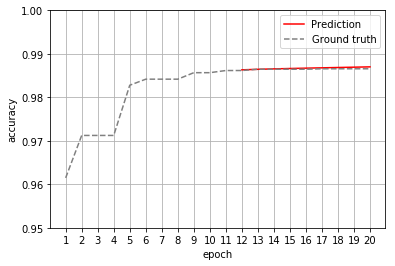

test case: 0
number of inputs: 12
predictive mean: 0.9868619034099901
predictive std: 0.00043518316936959394
ground truth: 0.986564


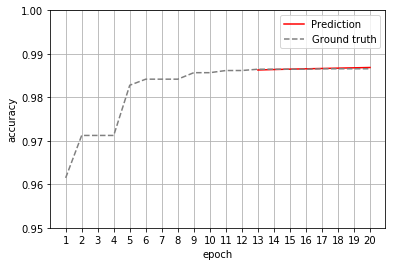

test case: 0
number of inputs: 13
predictive mean: 0.9870285796231452
predictive std: 0.0003671023946043446
ground truth: 0.986564


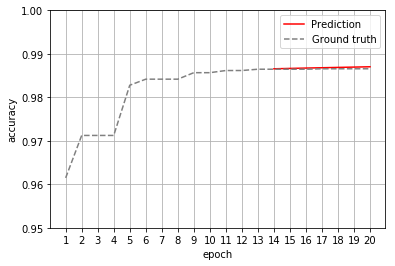

test case: 0
number of inputs: 14
predictive mean: 0.9869363556049985
predictive std: 0.00031001065315402164
ground truth: 0.986564


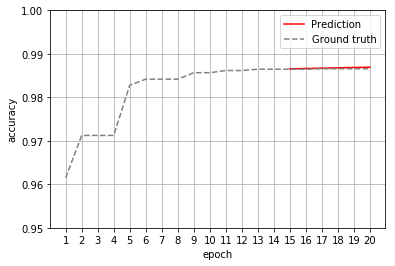

test case: 0
number of inputs: 15
predictive mean: 0.9868525205619156
predictive std: 0.0002540351281448753
ground truth: 0.986564


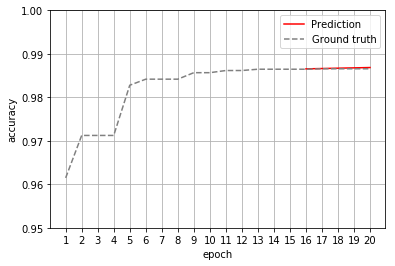

test case: 0
number of inputs: 16
predictive mean: 0.9867734250151068
predictive std: 0.0002000601524658402
ground truth: 0.986564


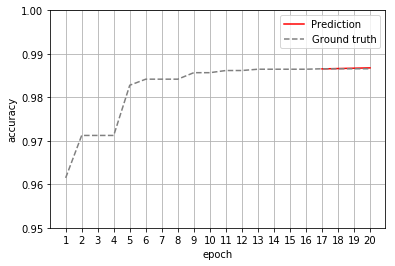

test case: 0
number of inputs: 17
predictive mean: 0.9867929765207396
predictive std: 0.00014677457319661475
ground truth: 0.986564


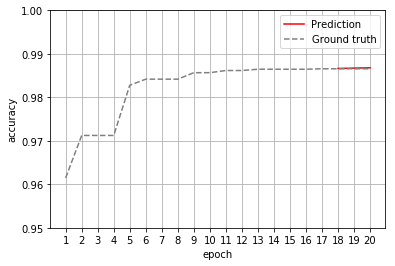

test case: 0
number of inputs: 18
predictive mean: 0.9867177358196214
predictive std: 9.692467576388345e-05
ground truth: 0.986564


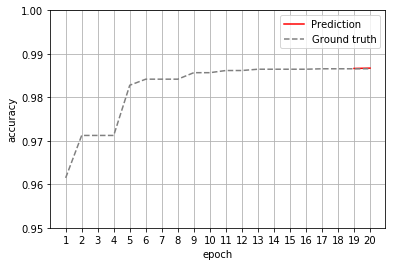

test case: 0
number of inputs: 19
predictive mean: 0.9866416431183805
predictive std: 4.818862190307515e-05
ground truth: 0.986564


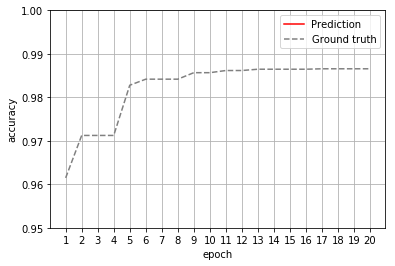

In [37]:
predictor = MultiPredictor(dataname, validation_dataname, N_sigma, dlen,
                           inputlen, N_ensembles, max_workers)
pred_df = pd.read_json('%s.json' % (validation_dataname), orient='split')
for target_num in range(N_test_cases):
    for i in range(dlen - inputlen):
        input_df = pred_df.iloc[target_num, :inputlen + i]
        tmp = input_df.copy()
        for i in range(1, input_df.shape[0]):
            tmp[i] = (input_df[i] - input_df[i - 1]) / (1 - input_df[i - 1])
        input_df = tmp
        predictions = predictor.predict(input_df)
        mean = predictions.mean()
        std = predictions.std()
        original = pred_df.iloc[target_num]
        print('test case: %s\nnumber of inputs: %s\npredictive mean: %s\npredictive std: %s\nground truth: %s' % (
            target_num, inputlen + i, mean.values[-1], std.values[-1], original.values[-1]))
        plot(mean, original)